In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import convolve2d
from PIL import Image
import argparse

## Assignment proper (original)

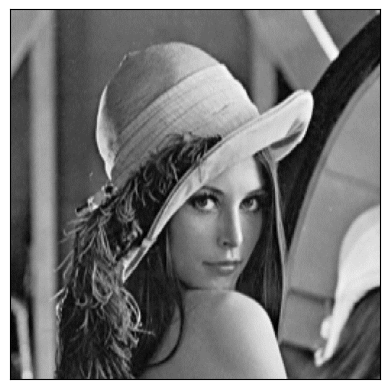

In [2]:
# Read in the image
im = np.array(Image.open('image_512.png').convert('L'))
plt.xticks([])
plt.yticks([])
plt.imshow(im, cmap = 'gray');

## Amended codes for different taps

In [3]:
def dwt2d(im, lvl, tap):
# Computing 2D discrete Haar wavelet transform of a given ndarray im.
# Parameters: 
#   im: ndarray.    An array representing image
#   lvl: integer.   An integer representing the level of wavelet decomposition
#   tap: integer.   An integer representing the tap of the wavelet filter
#  Returns:
#   out: ndarray.   An array representing  wavelet coefficients with lvl level. It has the same shape as im

# ----    
    # Define Daubechies wavelet coefficients based on 'tap' input
    if tap == 2:
        h = (np.array([1,1]) / np.sqrt(2)).reshape(2,1)
        g = (np.array([1,-1]) / np.sqrt(2)).reshape(2,1)
    elif tap == 4:
        h = (np.array([0.6830127, 1.1830127, 0.3169873, -0.1830127]) / np.sqrt(2)).reshape(4,1)
        g = (np.array([0.1830127, 0.3169873, -1.1830127, 0.6830127]) / np.sqrt(2)).reshape(4,1)
    elif tap == 6:
        h = (np.array([0.47046721, 1.14111692, 0.650365, -0.19093442, -0.12083221, 0.0498175]) / np.sqrt(2)).reshape(6,1)
        g = (np.array([-0.0498175, -0.12083221, 0.19093442, 0.650365, -1.14111692, 0.47046721]) / np.sqrt(2)).reshape(6,1)
        
    # Computes filters
    H = h @ h.T
    G1 = h @ g.T
    G2 = g @ h.T
    G3 = g @ g.T
    
    # Reverses filters
    H_rev = np.flip(H)
    G1_rev = np.flip(G1)
    G2_rev = np.flip(G2)    
    G3_rev = np.flip(G3)

    # Initializes out and s
    out = np.zeros(im.shape)
    s = im.copy()
    
    # Iterate
    for _ in range(lvl):
        
        # Convolve then downsample by factor 2
        if tap == 2:
            s_1 = convolve2d(s, H_rev, 'full', boundary='wrap')[1::2, 1::2]
            w_11 = convolve2d(s, G1_rev, 'full', boundary='wrap')[1::2, 1::2]
            w_12 = convolve2d(s, G2_rev, 'full', boundary='wrap')[1::2, 1::2]
            w_13 = convolve2d(s, G3_rev, 'full', boundary='wrap')[1::2, 1::2]
        elif tap == 4:
            s_1 = convolve2d(s, H_rev, 'full', boundary='wrap')[3::2, 3::2]
            w_11 = convolve2d(s, G1_rev, 'full', boundary='wrap')[3::2, 3::2]
            w_12 = convolve2d(s, G2_rev, 'full', boundary='wrap')[3::2, 3::2]
            w_13 = convolve2d(s, G3_rev, 'full', boundary='wrap')[3::2, 3::2]
        elif tap == 6:
            s_1 = convolve2d(s, H_rev, 'full', boundary='wrap')[5::2, 5::2]
            w_11 = convolve2d(s, G1_rev, 'full', boundary='wrap')[5::2, 5::2]
            w_12 = convolve2d(s, G2_rev, 'full', boundary='wrap')[5::2, 5::2]
            w_13 = convolve2d(s, G3_rev, 'full', boundary='wrap')[5::2, 5::2]
        
        # Arrange the matrices for output
        rows, cols = s_1.shape
        out[:rows, :cols] = s_1
        out[:rows, cols:cols*2] = w_11
        out[rows:rows*2, :cols] = w_12
        out[rows:rows*2, cols:cols*2] = w_13
        
        # Update 's' for the next iteration
        s = s_1.copy()
# ----
    return out

In [4]:
def idwt2d(im, lvl, tap):
# Computing an image in the form of ndarray from the ndarray coef which represents its DWT coefficients.
# Parameters: 
#   coef: ndarray   An array representing 2D Haar wavelet coefficients
#   lvl: integer.   An integer representing the level of wavelet decomposition
#   tap: integer.   An integer representing the tap of the wavelet filter
#  Returns:
#   out: ndarray.   An array representing the image reconstructed from its  wavelet coefficients.

# ----
    # Define Daubechies wavelet coefficients based on 'tap' input
    if tap == 2:
        h = (np.array([1,1]) / np.sqrt(2)).reshape(2,1)
        g = (np.array([1,-1]) / np.sqrt(2)).reshape(2,1)
    elif tap == 4:
        h = (np.array([0.6830127, 1.1830127, 0.3169873, -0.1830127]) / np.sqrt(2)).reshape(4,1)
        g = (np.array([0.1830127, 0.3169873, -1.1830127, 0.6830127]) / np.sqrt(2)).reshape(4,1)
    elif tap == 6:
        h = (np.array([0.47046721, 1.14111692, 0.650365, -0.19093442, -0.12083221, 0.0498175]) / np.sqrt(2)).reshape(6,1)
        g = (np.array([-0.0498175, -0.12083221, 0.19093442, 0.650365, -1.14111692, 0.47046721]) / np.sqrt(2)).reshape(6,1)
        
    # Computes filters
    H = h @ h.T
    G1 = h @ g.T
    G2 = g @ h.T
    G3 = g @ g.T
    
    # Initializes out, row and col references
    out = im.copy()
    row, col = (int(out.shape[0]/(2**lvl)), int(out.shape[1]/(2**lvl)))
                        
    # Iterate
    while lvl >= 1:
    
        # Split the input image into s, w1, w2, w3
        s = out[:row, :col]
        w1 = out[:row, col:col*2]
        w2 = out[row:row*2, :col]
        w3 = out[row:row*2, col:col*2]

        # Upsample each section by factor 2
        s_up = np.zeros((row*2, col*2))
        w1_up = np.zeros((row*2, col*2))
        w2_up = np.zeros((row*2, col*2))
        w3_up = np.zeros((row*2, col*2))

        s_up[0::2, 0::2] = s
        w1_up[0::2, 0::2] = w1
        w2_up[0::2, 0::2] = w2
        w3_up[0::2, 0::2] = w3

        # Convolve with the filters
        if tap == 2:
            s_conv = convolve2d(s_up, H, 'full', boundary='wrap')[0:-1,0:-1]
            w1_conv = convolve2d(w1_up, G1, 'full', boundary='wrap')[0:-1,0:-1]
            w2_conv = convolve2d(w2_up, G2, 'full', boundary='wrap')[0:-1,0:-1]
            w3_conv = convolve2d(w3_up, G3, 'full', boundary='wrap')[0:-1,0:-1]
        elif tap == 4:
            s_conv = convolve2d(s_up, H, 'full', boundary='wrap')[0:-3,0:-3]
            w1_conv = convolve2d(w1_up, G1, 'full', boundary='wrap')[0:-3,0:-3]
            w2_conv = convolve2d(w2_up, G2, 'full', boundary='wrap')[0:-3,0:-3]
            w3_conv = convolve2d(w3_up, G3, 'full', boundary='wrap')[0:-3,0:-3]
        elif tap == 6:
            s_conv = convolve2d(s_up, H, 'full', boundary='wrap')[0:-5,0:-5]
            w1_conv = convolve2d(w1_up, G1, 'full', boundary='wrap')[0:-5,0:-5]
            w2_conv = convolve2d(w2_up, G2, 'full', boundary='wrap')[0:-5,0:-5]
            w3_conv = convolve2d(w3_up, G3, 'full', boundary='wrap')[0:-5,0:-5]

        # Reconstruct by summing
        out[:row*2, :col*2] = s_conv + w1_conv + w2_conv + w3_conv
        
        # Reduce accumulator and double row & col references
        lvl -= 1
        row *= 2
        col *= 2
# ----
    return out

## Test output

(512, 512)


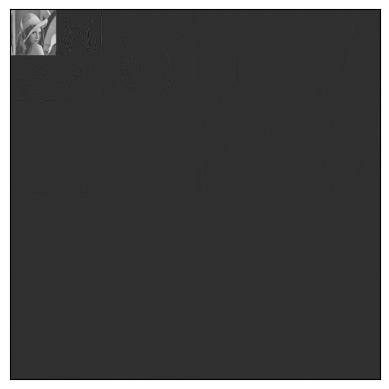

In [5]:
# Read in the image
signal = np.array(Image.open('image_512.png').convert('L'))

# Perform DWT
c = dwt2d(im=signal, lvl=3, tap=6)
print(c.shape)

# Visualise the output
plt.xticks([])
plt.yticks([])
plt.imshow(c, cmap = 'gray')
plt.show()

(512, 512)


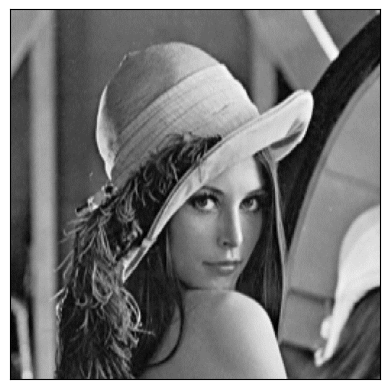

In [6]:
# Perform iDWT
x = idwt2d(im=c, lvl=3, tap=6)
print(x.shape)

# Visualise the output
plt.xticks([])
plt.yticks([])
plt.imshow(x, cmap = 'gray')
plt.show()

In [7]:
x

array([[153.00000094, 153.00000069, 153.00000044, ..., 153.00000138,
        170.00000135, 153.00000106],
       [153.00000152, 153.00000146, 136.00000103, ..., 170.00000199,
        170.00000188, 136.00000113],
       [153.00000126, 153.00000115, 153.00000094, ..., 153.0000018 ,
        170.00000179, 153.00000143],
       ...,
       [ 16.99999922,  33.999999  ,  33.99999899, ...,  68.00000017,
         85.00000049,  67.99999994],
       [ 16.999999  ,  16.99999871,  33.99999889, ...,  68.00000014,
         85.00000036,  67.99999999],
       [ 16.99999947,  16.99999893,  33.99999929, ...,  85.00000058,
         68.00000042,  85.00000056]])

In [8]:
im

array([[153, 153, 153, ..., 153, 170, 153],
       [153, 153, 136, ..., 170, 170, 136],
       [153, 153, 153, ..., 153, 170, 153],
       ...,
       [ 17,  34,  34, ...,  68,  85,  68],
       [ 17,  17,  34, ...,  68,  85,  68],
       [ 17,  17,  34, ...,  85,  68,  85]], dtype=uint8)

In [9]:
diff = x - im
print("Min diff: ", diff.min())
print("Max diff: ", diff.max())

Min diff:  -3.835226349613308e-06
Max diff:  4.8814885076353676e-06
